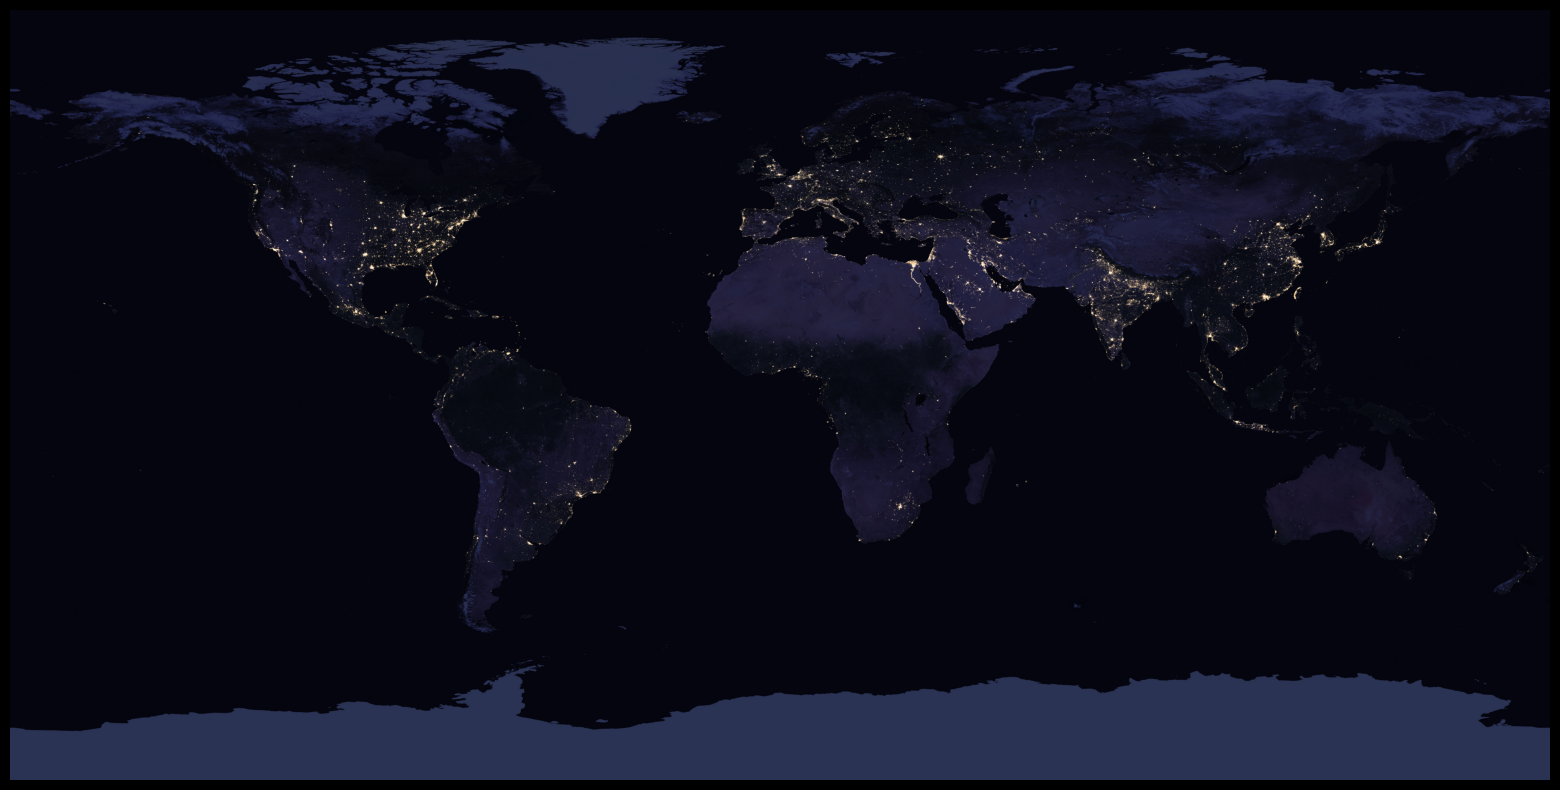

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import urllib.request
from pathlib import Path

# Config - NASA Black Marble Image
img_url = "https://eoimages.gsfc.nasa.gov/images/imagerecords/144000/144898/BlackMarble_2016_3km.jpg"
img_path = Path("night_lights_viirs_WGS84_ONLINE.jpg")

if not img_path.exists():
    print("Downloading high-res night lights map...")
    urllib.request.urlretrieve(img_url, img_path)

# Load Image
img = plt.imread(img_path)

# Plot WGS84
fig = plt.figure(figsize=(20, 10), facecolor='black')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('black')

# Display the global image
# The extent [-180, 180, -90, 90] covers the whole world
ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree())

#plt.title("VIIRS Night Lights - Global WGS84", color='white', size=15)
plt.axis('off')
plt.show()

Resolución original: 13500x6750 píxeles
✅ Conversión terminada: night_lights_viirs_WGS84.png
Confirmación de salida: 13500x6750 píxeles


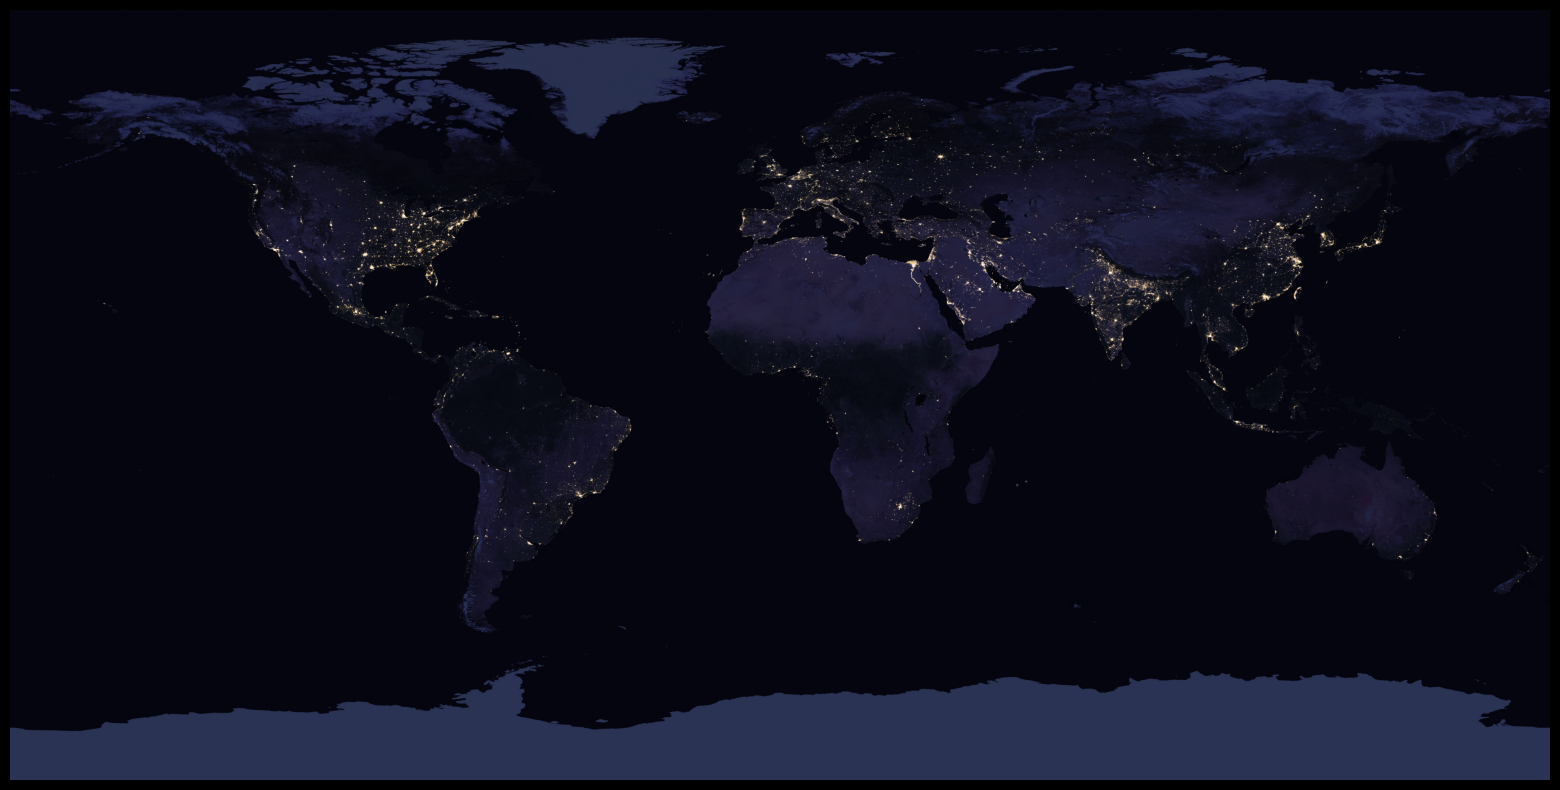

In [22]:
from PIL import Image
from pathlib import Path

# Configuración de archivos
img_input = Path("night_lights_viirs_WGS84_ONLINE.jpg")
img_output = Path("night_lights_viirs_WGS84.png")

if not img_input.exists():
    print(f"❌ No se encuentra el archivo: {img_input}")
else:
    # Abrir la imagen original
    with Image.open(img_input) as im:
        print(f"Resolución original: {im.size[0]}x{im.size[1]} píxeles")
        
        # Guardar como PNG con la misma resolución
        # Usamos optimize=True para que el archivo no pese demasiado 
        # sin perder ni un solo píxel de calidad.
        im.save(img_output, "PNG", optimize=True)
        
    print(f"✅ Conversión terminada: {img_output}")
    
    # Verificación final
    with Image.open(img_output) as im_check:
        print(f"Confirmación de salida: {im_check.size[0]}x{im_check.size[1]} píxeles")

    
    # Load Image
    img = plt.imread(img_output)

    # Plot WGS84
    fig = plt.figure(figsize=(20, 10), facecolor='black')
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_facecolor('black')

    # Display the global image
    # The extent [-180, 180, -90, 90] covers the whole world
    ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree())

    #plt.title("VIIRS Night Lights - Global WGS84", color='white', size=15)
    plt.axis('off')
    plt.show()

⏳ Procesando máscara de continentes (esto puede tardar unos segundos)...
✅ ¡Éxito! Mapa WGS84 con océano transparente guardado en: night_lights_viirs_WGS84_only_land.png


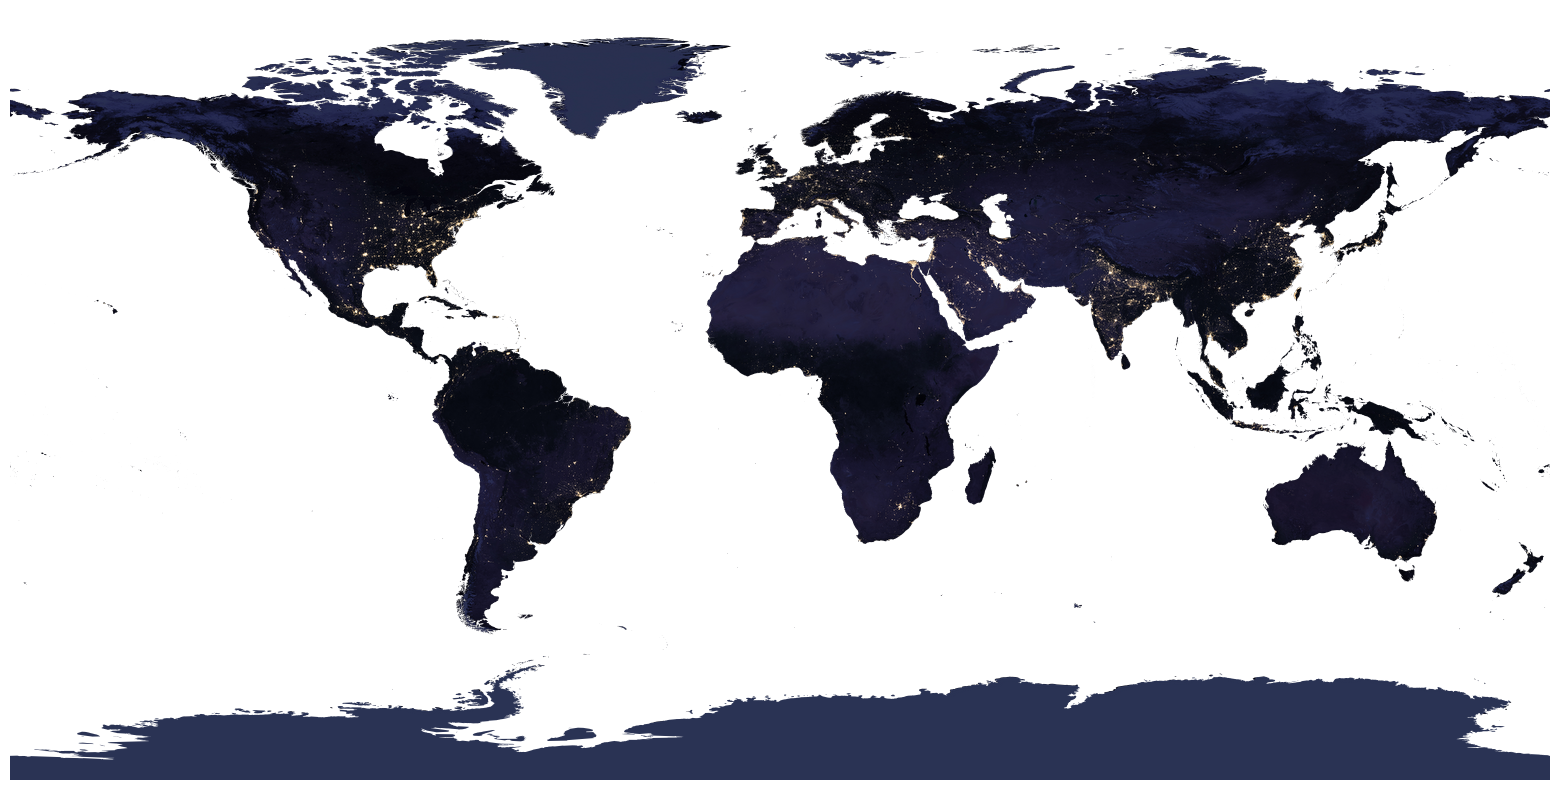

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
from pathlib import Path
from PIL import Image
import numpy as np
from shapely.ops import unary_union

# 1. Seguridad para imágenes grandes
Image.MAX_IMAGE_PIXELS = None 

# Archivos
img_input = Path("night_lights_viirs_WGS84.png")
output_name = "night_lights_viirs_WGS84_only_land.png"

if not img_input.exists():
    print(f"❌ Error: No se encuentra {img_input}")
else:
    img = plt.imread(img_input)
    
    # 2. Setup de la Proyección Plana
    fig = plt.figure(figsize=(20, 10), facecolor='none')
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Hacer el fondo transparente
    ax.patch.set_visible(False)
    
    # FIX: En versiones nuevas de Cartopy, outline_patch no existe.
    # Usamos spines directamente.
    if hasattr(ax, 'spines'):
        ax.spines['geo'].set_visible(False)

    # 3. Dibujar la imagen
    img_plot = ax.imshow(img, origin='upper', 
                         extent=[-180, 180, -90, 90], 
                         transform=ccrs.PlateCarree(), 
                         interpolation='lanczos')

    # 4. --- EL CORTE DEFINITIVO (CLIPPING) ---
    print("⏳ Procesando máscara de continentes (esto puede tardar unos segundos)...")
    land_geom = cfeature.NaturalEarthFeature('physical', 'land', '10m').geometries()
    merged_land = unary_union(list(land_geom))
    
    def shapely_to_path(geom):
        if geom.is_empty: return mpath.Path([(0,0)])
        poly_paths = []
        # Manejar polígonos y multipolígonos de forma segura
        geos = geom.geoms if hasattr(geom, 'geoms') else [geom]
        for poly in geos:
            if poly.is_empty: continue
            paths = [mpath.Path(np.array(poly.exterior.coords))]
            for interior in poly.interiors:
                paths.append(mpath.Path(np.array(interior.coords)))
            poly_paths.append(mpath.Path.make_compound_path(*paths))
        return mpath.Path.make_compound_path(*poly_paths)

    clip_path = shapely_to_path(merged_land)
    
    # Aplicar el recorte a la imagen
    img_plot.set_clip_path(clip_path, transform=ax.transData)

    # 5. Guardado en Alta Resolución
    plt.savefig(
        output_name, 
        dpi=300, 
        transparent=True, 
        bbox_inches='tight', 
        pad_inches=0
    )
    
    print(f"✅ ¡Éxito! Mapa WGS84 con océano transparente guardado en: {output_name}")
    plt.show()

✅ Saved successfully: night_lights_viirs_GOES_EAST.png


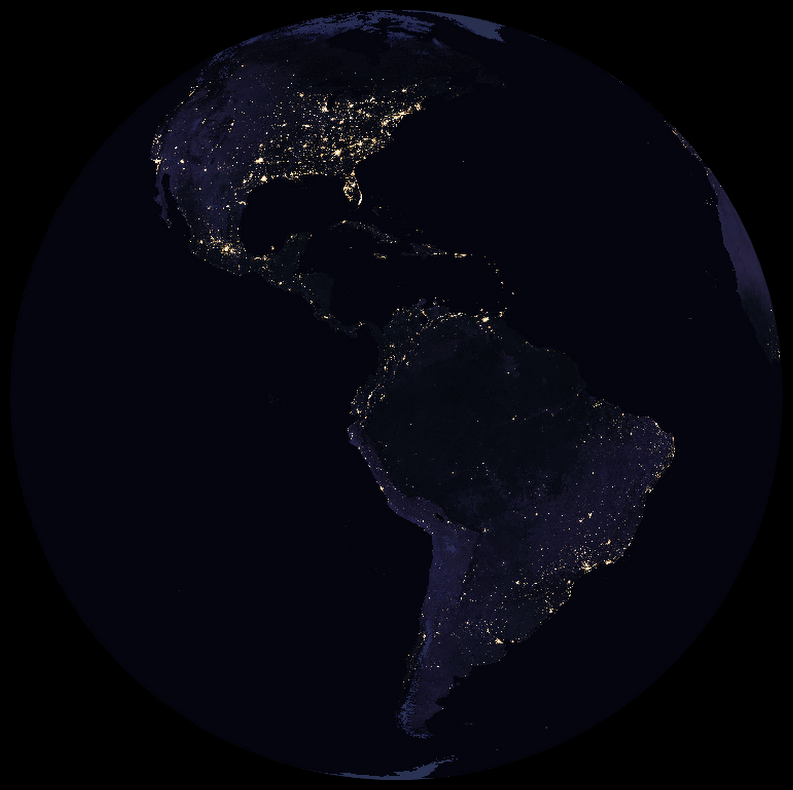

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from PIL import Image

# 1. EVITAR EL WARNING DE BOMBA DE DESCOMPRESIÓN
# Esto permite procesar imágenes de gran tamaño en memoria
Image.MAX_IMAGE_PIXELS = None 

# Config
img_input = Path("night_lights_viirs_WGS84.png")
output_name = "night_lights_viirs_GOES_EAST.png"

if not img_input.exists():
    print(f"❌ Error: File {img_input} not found.")
else:
    img = plt.imread(img_input)
    goes_crs = ccrs.Geostationary(central_longitude=-75.0)

    # Ajustamos figsize a 10x10 para tener mejor control
    fig = plt.figure(figsize=(10, 10), facecolor='black')
    ax = plt.axes(projection=goes_crs)
    ax.set_facecolor('black')
    ax.set_global()

    # Plot
    ax.imshow(img, origin='upper', 
              extent=[-180, 180, -90, 90], 
              transform=ccrs.PlateCarree(), 
              alpha=1.0,
              interpolation='lanczos')

    plt.axis('off')

    # --- MÉTODO DE GUARDADO SEGURO ---
    # Eliminamos 'quality' y 'optimize' para que sea compatible con todos los backends
    # Si quieres JPG, el backend estándar lo hará por defecto con buena calidad.
    try:
        plt.savefig(
            output_name, 
            dpi=500,                # 10 * 500 = 5000px ancho
            facecolor='black', 
            bbox_inches='tight', 
            pad_inches=0
        )
        print(f"✅ Saved successfully: {output_name}")
    except Exception as e:
        print(f"❌ Error al guardar: {e}")
        print("Intentando guardar como PNG...")
        plt.savefig(output_name, dpi=500, facecolor='black', bbox_inches='tight', pad_inches=0)

    plt.show()

✅ Guardado con transparencia: night_lights_viirs_GOES_EAST_FullDisk.png


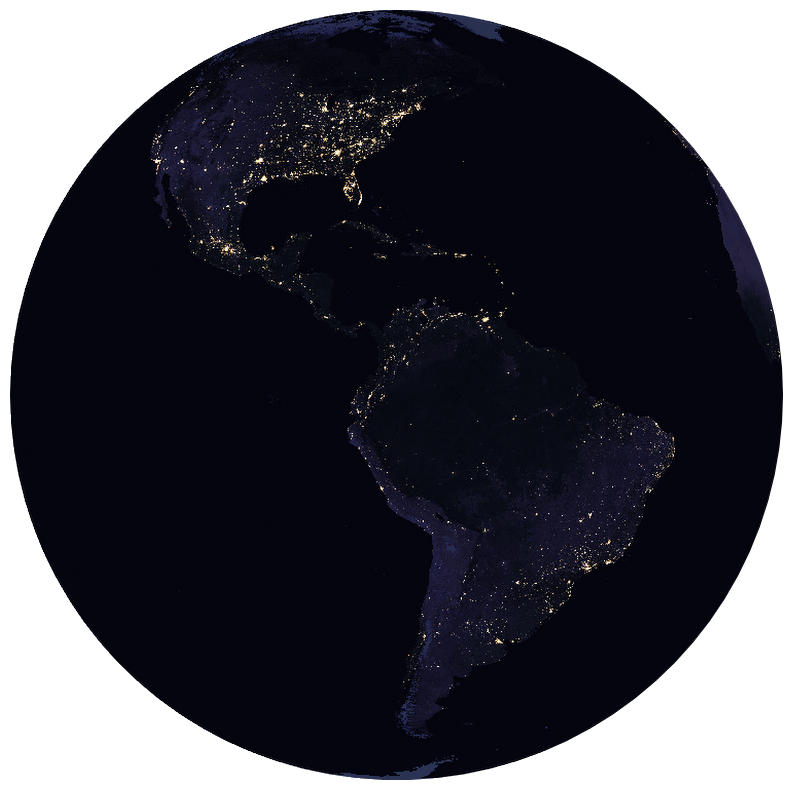

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from PIL import Image

# 1. Permitir imágenes grandes
Image.MAX_IMAGE_PIXELS = None 

# Configuración
img_input = Path("night_lights_viirs_WGS84.png")
# Cambiamos extensión a .png para soportar transparencia
output_name =  "night_lights_viirs_GOES_EAST_FullDisk.png"

if not img_input.exists():
    print(f"❌ Error: No se encuentra el archivo {img_input}")
else:
    img = plt.imread(img_input)
    
    # Proyección GOES-East (-75.0)
    goes_crs = ccrs.Geostationary(central_longitude=-75.0)

    # Definimos la figura con fondo transparente
    fig = plt.figure(figsize=(10, 10), facecolor='none') 
    ax = plt.axes(projection=goes_crs)
    
    # Fondo del hacha (el cuadrado) transparente
    ax.set_facecolor('none')
    ax.set_global()

    # Dibujar el mapa base
    ax.imshow(img, origin='upper', 
              extent=[-180, 180, -90, 90], 
              transform=ccrs.PlateCarree(), 
              alpha=1.0,
              interpolation='lanczos')

    # IMPORTANTE: Quitamos el marco del mapa para que no salga el cuadro negro/blanco
    ax.spines['geo'].set_visible(False)
    plt.axis('off')

    # --- GUARDADO CON TRANSPARENCIA ---
    try:
        plt.savefig(
            output_name, 
            dpi=500, 
            transparent=True,    # Esta es la clave
            bbox_inches='tight', 
            pad_inches=0
        )
        print(f"✅ Guardado con transparencia: {output_name}")
    except Exception as e:
        print(f"❌ Error al guardar: {e}")

    plt.show()

✅ Guardado con transparencia: night_lights_viirs_GOES_EAST_only_land.png


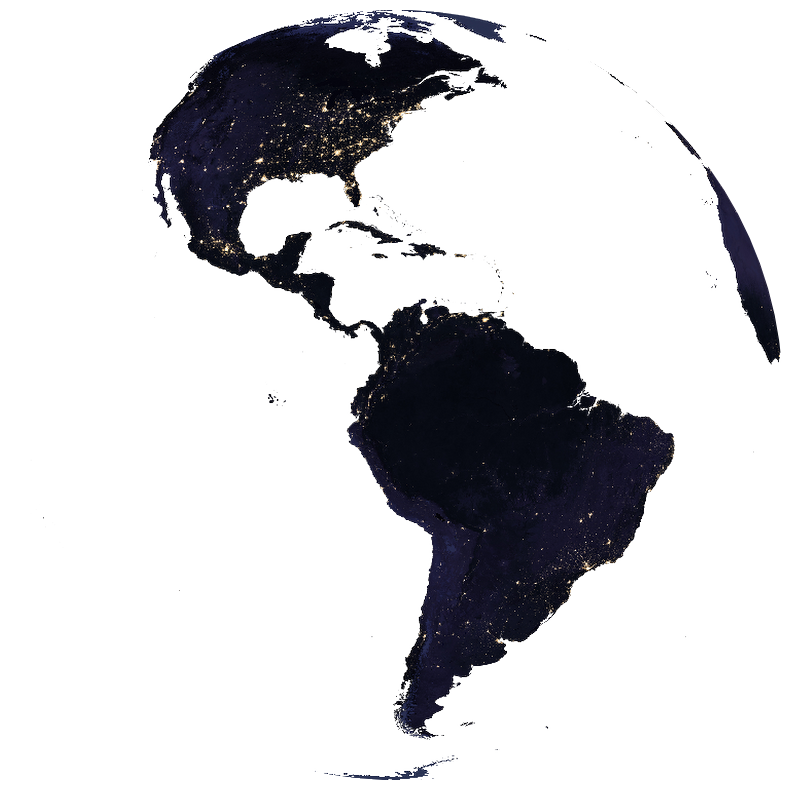

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from PIL import Image

# 1. Permitir imágenes grandes
Image.MAX_IMAGE_PIXELS = None 

# Configuración
img_input = Path("night_lights_viirs_WGS84_only_land.png")
# Cambiamos extensión a .png para soportar transparencia
output_name =  "night_lights_viirs_GOES_EAST_only_land.png"

if not img_input.exists():
    print(f"❌ Error: No se encuentra el archivo {img_input}")
else:
    img = plt.imread(img_input)
    
    # Proyección GOES-East (-75.0)
    goes_crs = ccrs.Geostationary(central_longitude=-75.0)

    # Definimos la figura con fondo transparente
    fig = plt.figure(figsize=(10, 10), facecolor='none') 
    ax = plt.axes(projection=goes_crs)
    
    # Fondo del hacha (el cuadrado) transparente
    ax.set_facecolor('none')
    ax.set_global()

    # Dibujar el mapa base
    ax.imshow(img, origin='upper', 
              extent=[-180, 180, -90, 90], 
              transform=ccrs.PlateCarree(), 
              alpha=1.0,
              interpolation='lanczos')

    # IMPORTANTE: Quitamos el marco del mapa para que no salga el cuadro negro/blanco
    ax.spines['geo'].set_visible(False)
    plt.axis('off')

    # --- GUARDADO CON TRANSPARENCIA ---
    try:
        plt.savefig(
            output_name, 
            dpi=500, 
            transparent=True,    # Esta es la clave
            bbox_inches='tight', 
            pad_inches=0
        )
        print(f"✅ Guardado con transparencia: {output_name}")
    except Exception as e:
        print(f"❌ Error al guardar: {e}")

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from PIL import Image

# 1. EVITAR EL WARNING DE BOMBA DE DESCOMPRESIÓN
# Esto permite procesar imágenes de gran tamaño en memoria
Image.MAX_IMAGE_PIXELS = None 

# Config
img_input = Path("night_lights_viirs_WGS84_only_land.png")
output_name = "night_lights_viirs_GOES_EAST_only_land.png"

if not img_input.exists():
    print(f"❌ Error: File {img_input} not found.")
else:
    img = plt.imread(img_input)
    goes_crs = ccrs.Geostationary(central_longitude=-75.0)

    # Ajustamos figsize a 10x10 para tener mejor control
    fig = plt.figure(figsize=(10, 10), facecolor='black')
    ax = plt.axes(projection=goes_crs)
    ax.set_facecolor('black')
    ax.set_global()

    # Plot
    ax.imshow(img, origin='upper', 
              extent=[-180, 180, -90, 90], 
              transform=ccrs.PlateCarree(), 
              alpha=1.0,
              interpolation='lanczos')

    plt.axis('off')

    # --- MÉTODO DE GUARDADO SEGURO ---
    # Eliminamos 'quality' y 'optimize' para que sea compatible con todos los backends
    # Si quieres JPG, el backend estándar lo hará por defecto con buena calidad.
    try:
        plt.savefig(
            output_name, 
            dpi=500,                # 10 * 500 = 5000px ancho
            bbox_inches='tight', 
            pad_inches=0
        )
        print(f"✅ Saved successfully: {output_name}")
    except Exception as e:
        print(f"❌ Error al guardar: {e}")
        print("Intentando guardar como PNG...")
        plt.savefig(output_name, dpi=500, facecolor='black', bbox_inches='tight', pad_inches=0)

    plt.show()